# Neural Network for Predicting Average Heart Rate

In [ ]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# drive.mount('/content/drive') # for colab

Mounted at /content/drive


#### Data processing function for normalization and OHE

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def process_data(data):
  """
  Function that normalizes numerical columns and one-hot encodes categorical columns.

  Params
  ------
  data: pd.DataFrame
    Dataframe to be processed, already filtered to exclude unwanted columns.

  Returns
  -------
  data: pd.DataFrame
    Processed dataframe.
  """
  # seperate the columns into categorical and quantitative
  cat = data.select_dtypes(include=["object"])
  quant = data.select_dtypes(include=["number"])

  # normalize quantitative columns using StandardScaler
  scaler = StandardScaler()
  data[quant.columns] = scaler.fit_transform(quant)

  # one-hot encode categorical columns using OneHotEncoder
  ohe = OneHotEncoder(sparse=False, drop=None)
  cat_encoded = ohe.fit_transform(cat)
  cat_encoded_df = pd.DataFrame(cat_encoded, columns=ohe.get_feature_names_out(cat.columns))

  # combine the dataframes back together
  data.reset_index(drop=True, inplace=True)
  cat_encoded_df.reset_index(drop=True, inplace=True)
  data = pd.concat([data[quant.columns], cat_encoded_df], axis=1)

  return data

In [ ]:
# read in dataset sample
# df = pd.read_csv('drive/MyDrive/meta_with_hr.csv').drop(columns=["Unnamed: 0"]) COLAB VERSION
df = pd.read_csv('../data/meta_with_hr.csv').drop(columns=["Unnamed: 0"]) # THIS IS ON THE GOOGLE DRIVE LINK!!!

In [ ]:
# converts the string into a python list
df["heart_rate"] = df["heart_rate"].apply(ast.literal_eval)

In [ ]:
# calculates the max heart rate, used for data processing
df["max_hr"] = df["heart_rate"].apply(lambda x: np.max(x))

In [ ]:
class NeuralNet(nn.Module):
  """
  Simple deep neural network with 3 hidden layers, using the ReLU activation function.
  """
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return x


In [ ]:
# remove outliers
data = df.drop(columns=["userId", "hydration", "id", "timestamp", "url", "weather", "heart_rate"])
data = data.dropna()
data = data[data["calories"] < 5000]
data = data[data["calories"] > 10]
data = data[data["max_hr"] >= 60]
data = data[data["max_hr"] <= 230]
data["calories"] = np.log(data["calories"])
data["duration"] = np.log(data["duration"])
y = data["mean_hr"]
data = data.drop(columns=["mean_hr", "max_hr", "calories"])
data = data.dropna()
data = process_data(data)
data

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,ascent,descent,duration,distance,sport_bike,sport_bike (transport),sport_core stability training,sport_cross-country skiing,sport_elliptical,sport_hiking,...,sport_mountain bike,sport_orienteering,sport_rowing,sport_run,sport_skate,sport_walk,sport_weight training,gender_female,gender_male,gender_unknown
0,-0.271088,-0.262156,-0.528143,-0.747802,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.322127,0.338879,0.678200,0.433042,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.414278,0.382625,0.489715,0.547124,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.284527,-0.281176,-0.271941,-0.775634,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.025355,-0.018699,-0.170522,-0.115600,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,0.575540,0.569022,0.612262,-0.047957,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9561,-0.257650,-0.273568,-1.670966,-0.732202,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9562,-0.334441,-0.326824,-1.633791,-0.766019,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9563,-0.184698,-0.184174,-0.309773,-0.205168,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# split data into training and testing, convert to tensors
train_X, test_X, train_y, test_y = train_test_split(data, y, test_size=0.2, shuffle=True, random_state=42)
train_X = torch.tensor(train_X.values, dtype=torch.float32)
train_y = torch.tensor(train_y.values, dtype=torch.float32)
kf = KFold(n_splits=3, shuffle=True, random_state=42)

#### Training the model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5101])) that is different to the input size (torch.Size([5101, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2551])) that is different to the input size (torch.Size([2551, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


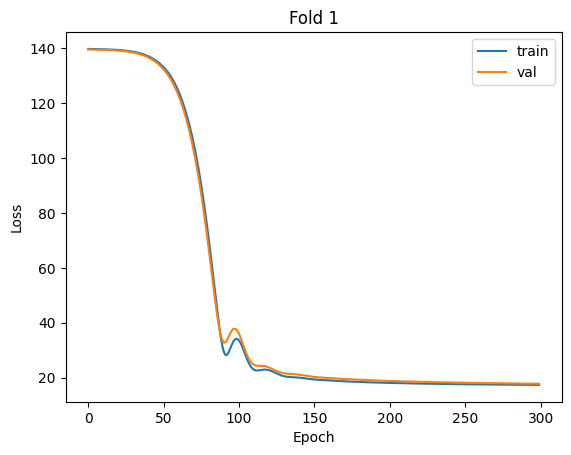

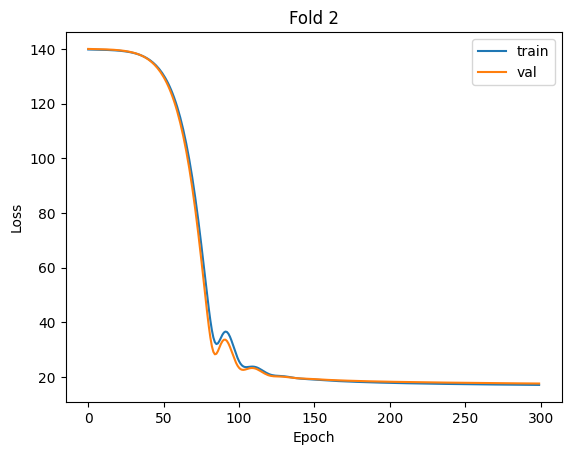

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5102])) that is different to the input size (torch.Size([5102, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2550])) that is different to the input size (torch.Size([2550, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


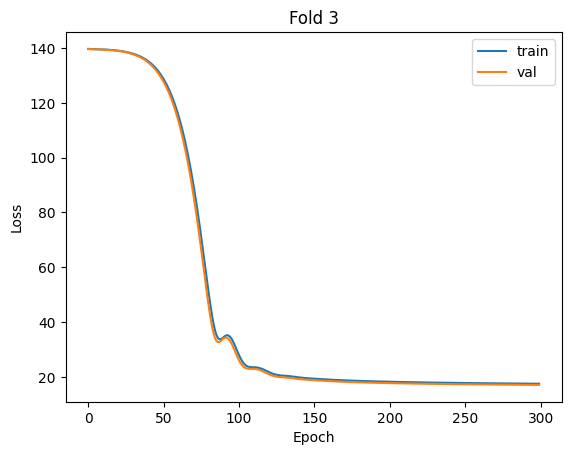

In [ ]:
fold = 0
lowest_val = 1000000
hr_weights = None

# do 3-fold cross validation for training and validating
for train_index, test_index in kf.split(train_X):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]
    input_size = train_X.shape[1]
    output_size = 1
    hr_model = NeuralNet(input_size, output_size)

    # Loss and optimizer
    loss_func = nn.MSELoss()
    optimizer = optim.Adam(hr_model.parameters(), lr=0.001, weight_decay=1e-8)

    # Training loop
    num_epochs = 300
    losses = []
    val_losses = []
    for epoch in range(num_epochs):
          # Forward pass
          outputs = hr_model(X_train)
          loss = loss_func(outputs, y_train)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          losses.append(np.sqrt(loss.item()))

          # Validation, store the lowest validation error
          with torch.no_grad():
              outputs = hr_model(X_test)
              loss = loss_func(outputs, y_test)
              val_losses.append(np.sqrt(loss.item()))
              if np.sqrt(loss.item()) < lowest_val:
                  lowest_val = np.sqrt(loss.item())
                  weights = hr_model.state_dict()
    fold += 1
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train", "val"])
    plt.title(f"Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig(f"../figures/fold{fold}.png")
    plt.show()

In [ ]:
lowest_val

17.100464110740806

In [ ]:
from sklearn.metrics import mean_squared_error

# evaluate model using test set and RMSE
test_X = torch.tensor(test_X.values, dtype=torch.float32)

y_pred = hr_model(test_X).detach().numpy()
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print(f"RMSE: {rmse}")

RMSE: 18.810263420996574


In [ ]:
test_y.shape
y_pred = y_pred.reshape(-1)

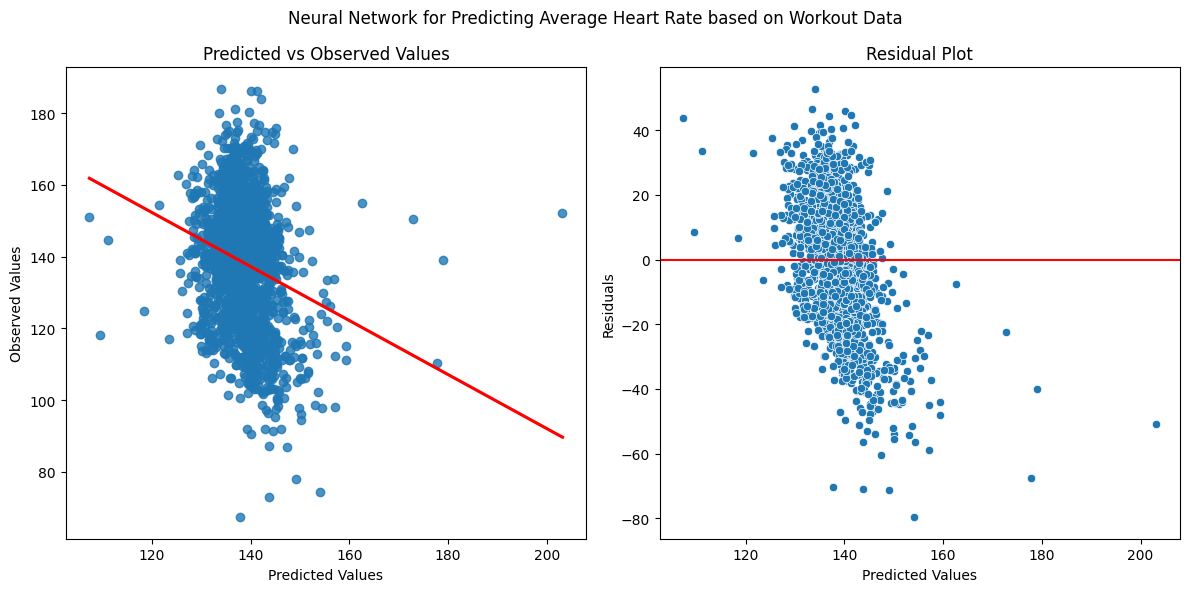

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(121)
# 1. plot predictions vs. observations
sns.regplot(x=y_pred, y=test_y, ci=None, line_kws={'color':'red'});
plt.title("Predicted vs Observed Values")
plt.xlabel("Predicted Values")
plt.ylabel("Observed Values")

plt.subplot(122)
# 2. plot residual plot
sns.scatterplot(x=y_pred, y=test_y - y_pred)
plt.axhline(y=0, color='red')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.suptitle("Neural Network for Predicting Average Heart Rate based on Workout Data")
plt.tight_layout()
plt.savefig("../figures/nn_pred.png")
plt.show()